In [1]:
import os
import importlib
import warnings
from collections import Counter
import numpy as np
import pandas as pd
from scipy import stats
from matplotlib import pyplot as plt
import seaborn as sns

from utils.data import DataTree
import snapfish2 as sf
importlib.reload(sf)

<module 'snapfish2' from '/Users/redfishhh/Documents/research/MultiplexedFISH/LoopTests/snapfish2/__init__.py'>

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
out_dire = "../123ACElog/013125"

In [4]:
dtree = DataTree("../data")
celltype_dict = {1:'Pvalb', 2:'Vip', 3:'Ndnf', 4:'Sst', 5:'Astro', 
                 6:'Micro', 7:'Endo', 8:'Oligo', 9:'Ex'}
dfs = []
for k in ["rep1", "rep2", "rep3"]:
    data_name = dtree["takei_science_2021","25Kb",k]
    df = sf.MulFish(data_name).data
    df["Trace_ID"] = k + "_" + df["Trace_ID"]  # Ensure Trace_ID is unique
    df["Replicate"] = k
    df["X"] *= 103; df["Y"] *= 103; df["Z"] *= 250  # Convert to nm
    cty_name = dtree["takei_science_2021","cell_type",k]
    cty_df = sf.MulFish(cty_name).data
    cty_df["label"] = cty_df["cluster label"].map(celltype_dict)
    df = pd.merge(df, cty_df[["Cell_ID","label"]], how="left", on="Cell_ID")
    dfs.append(df)
mfr = sf.MulFish(pd.concat(dfs, ignore_index=True))
del df, dfs

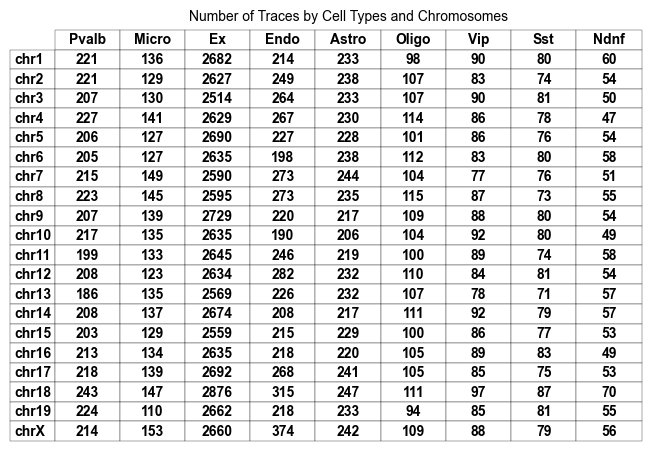

In [5]:
rows = []
for chr_id in pd.unique(mfr.data["Chrom"]):
    d = Counter(mfr[chr_id].drop_duplicates(["Trace_ID", "label"]).label)
    d["Chrom"] = chr_id
    rows.append(d)
df = pd.DataFrame(rows).sort_values("Chrom").set_index("Chrom")
df = df.loc[[f"chr{i}" for i in range(1, 20)]+["chrX"]]
fig, ax = plt.subplots()
ax.axis("off")
ax.table(cellText=df.values, colLabels=df.columns, rowLabels=df.index, 
         cellLoc="center", loc="center")
ax.set_title("Number of Traces by Cell Types and Chromosomes", 
             y=1.02, fontsize=10)
out_fname = os.path.join(out_dire, "takei_science_count.pdf")
fig.savefig(out_fname, bbox_inches="tight")

## Differential TAD demo

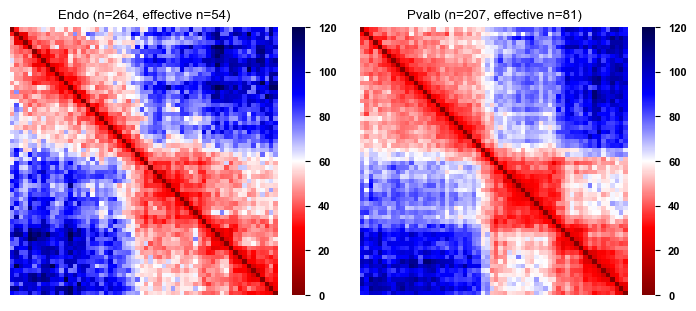

In [13]:
chr_id, lbl1, lbl2 = "chr3", "Endo", "Pvalb"
data1, data2 = mfr[chr_id, ("label",lbl1)], mfr[chr_id, ("label",lbl2)]

arr1 = sf.utils.load.to_very_wide(data1)[1]
dist1 = np.nanmedian(np.sqrt(np.sum(np.square(arr1), axis=1)), axis=0)
arr2 = sf.utils.load.to_very_wide(data2)[1]
dist2 = np.nanmedian(np.sqrt(np.sum(np.square(arr2), axis=1)), axis=0)

effn1 = int(np.nanmedian(np.sum(~np.isnan(arr1), axis=0)))
effn2 = int(np.nanmedian(np.sum(~np.isnan(arr2), axis=0)))
x = f"{lbl1} (n={arr1.shape[0]}, effective n={effn1})"
y = f"{lbl2} (n={arr2.shape[0]}, effective n={effn2})"

fig, axes = plt.subplots(1, 2, figsize=(7, 3))
sf.pl.pairwise_heatmap(dist1, ax=axes[0], title=x, vmax=120)
sf.pl.pairwise_heatmap(dist2, ax=axes[1], title=y, vmax=120)
out_fname = os.path.join(out_dire, f"{lbl1}_{lbl2}_{chr_id}_hm.pdf")
fig.savefig(out_fname, bbox_inches="tight")

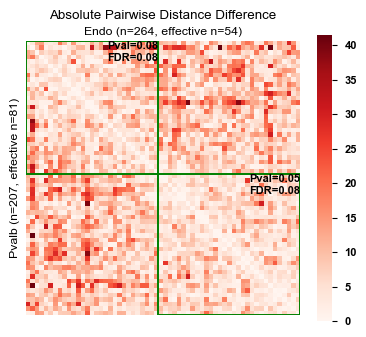

In [14]:
std1 = sf.domain.TADCaller(data1, 2e5, "carr")
tadres1 = std1.by_pval(0.1)
tadbedpe1 = std1.to_bedpe(tadres1, "stat", True)

sdr1 = sf.domain.DiffRegion(data1, data2, "carr")
diff1 = sdr1.diff_region(tadbedpe1[tadbedpe1["level"].isin([1,2])])

fig, axes = sf.pl.plot_TAD_boundary(tadres1, diff1, [], ["g"]*4, [], diff=True)
sf.pl.pairwise_heatmap(np.abs(dist1-dist2), cmap="Reds", ax=axes[0], x=x, y=y)
axes[0].set_title("Absolute Pairwise Distance Difference")
out_fname = os.path.join(out_dire, f"{lbl1}_{lbl2}_{chr_id}_diff.pdf")
fig.savefig(out_fname, bbox_inches="tight")

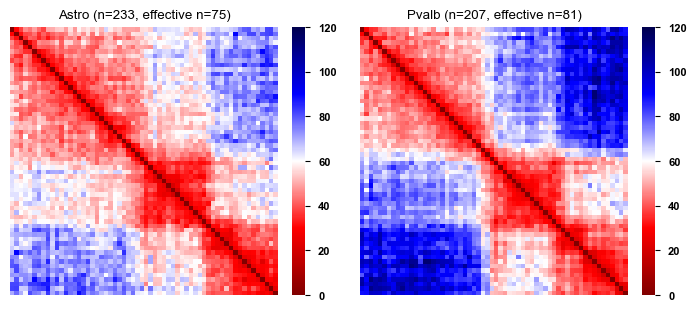

In [15]:
chr_id, lbl1, lbl2 = "chr3", "Astro", "Pvalb"
data1, data2 = mfr[chr_id, ("label",lbl1)], mfr[chr_id, ("label",lbl2)]

arr1 = sf.utils.load.to_very_wide(data1)[1]
dist1 = np.nanmedian(np.sqrt(np.sum(np.square(arr1), axis=1)), axis=0)
arr2 = sf.utils.load.to_very_wide(data2)[1]
dist2 = np.nanmedian(np.sqrt(np.sum(np.square(arr2), axis=1)), axis=0)

effn1 = int(np.nanmedian(np.sum(~np.isnan(arr1), axis=0)))
effn2 = int(np.nanmedian(np.sum(~np.isnan(arr2), axis=0)))
x = f"{lbl1} (n={arr1.shape[0]}, effective n={effn1})"
y = f"{lbl2} (n={arr2.shape[0]}, effective n={effn2})"

fig, axes = plt.subplots(1, 2, figsize=(7, 3))
sf.pl.pairwise_heatmap(dist1, ax=axes[0], title=x, vmax=120)
sf.pl.pairwise_heatmap(dist2, ax=axes[1], title=y, vmax=120)
out_fname = os.path.join(out_dire, f"{lbl1}_{lbl2}_{chr_id}_hm.pdf")
fig.savefig(out_fname, bbox_inches="tight")

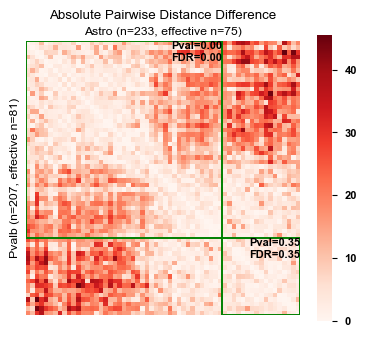

In [21]:
std1 = sf.domain.TADCaller(data1, 2e5, "carr")
tadres1 = std1.by_pval(0.1)
tadbedpe1 = std1.to_bedpe(tadres1, "stat", True)

sdr1 = sf.domain.DiffRegion(data1, data2, "carr")
diff1 = sdr1.diff_region(tadbedpe1[tadbedpe1["level"].isin([1, 3])])

fig, axes = sf.pl.plot_TAD_boundary(tadres1, diff1, [], ["g"]*4, [], diff=True)
sf.pl.pairwise_heatmap(np.abs(dist1-dist2), cmap="Reds", ax=axes[0], x=x, y=y)
axes[0].set_title("Absolute Pairwise Distance Difference")
out_fname = os.path.join(out_dire, f"{lbl1}_{lbl2}_{chr_id}_diff.pdf")
fig.savefig(out_fname, bbox_inches="tight")

In [24]:
lbl = "Pvalb"
std2 = sf.domain.TADCaller(mfr[("label",lbl)], 1e5, "carr")
tadres2 = std2.by_pval(.1)
tadbedpe2 = std2.to_bedpe(tadres2, "stat", True)

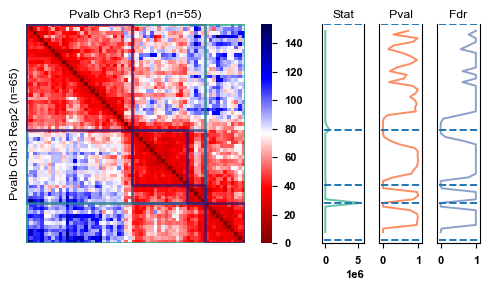

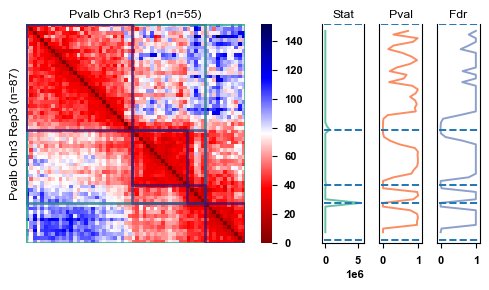

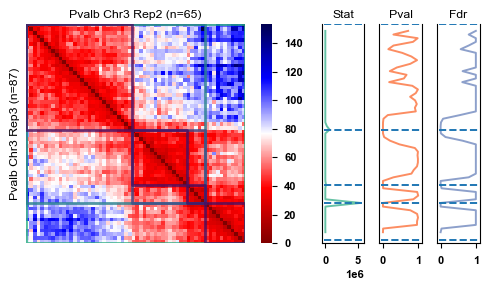

In [27]:
from itertools import combinations
rep_comb = combinations(pd.unique(std2._data["Replicate"]), 2)
diffbedpes = []
for rep1, rep2 in rep_comb:
    data1 = mfr[("label",lbl), ("Replicate", rep1)]
    data2 = mfr[("label",lbl), ("Replicate", rep2)]

    sdr2 = sf.domain.DiffRegion(data1, data2, "carr")
    diffbedpe = sdr2.diff_region(tadbedpe2)
    diffbedpe["Replicate"] = f"{rep1}&{rep2}".title()
    diffbedpes.append(diffbedpe)

    chr_id = "chr3"
    arr1 = sf.utils.load.to_very_wide(data1[data1["Chrom"]==chr_id])[1]
    dist1 = np.nanmedian(np.sqrt(np.sum(np.square(arr1), axis=1)), axis=0)
    arr2 = sf.utils.load.to_very_wide(data2[data2["Chrom"]==chr_id])[1]
    dist2 = np.nanmedian(np.sqrt(np.sum(np.square(arr2), axis=1)), axis=0)

    res = tadres2[tadres2["c1"]==chr_id]
    tadbedpe = tadbedpe2[tadbedpe2["c1"]==chr_id]
    fig, axes = sf.pl.plot_TAD_boundary(
        result=res, bedpe=tadbedpe,
        cols=["stat", "pval", "fdr"], 
        tad_colors=[plt.get_cmap("viridis")(i*50+10) for i in range(10)],
        line_colors=[plt.get_cmap("Set2")(i) for i in range(10)],
        linewidth=2, alpha=.8
    )
    sf.pl.pairwise_heatmap(
        X1=dist1, X2=dist2, ax=axes[0],
        x=f"{lbl} {chr_id.title()} {rep1.title()} (n={arr1.shape[0]})", 
        y=f"{lbl} {chr_id.title()} {rep2.title()} (n={arr2.shape[0]})"
    )
    os.path.join(out_dire, f"{rep1}_{rep2}_{lbl}.pdf")
    fig.tight_layout()
    fig.savefig(out_fname, bbox_inches="tight")
diffbedpes = pd.concat(diffbedpes, ignore_index=True)

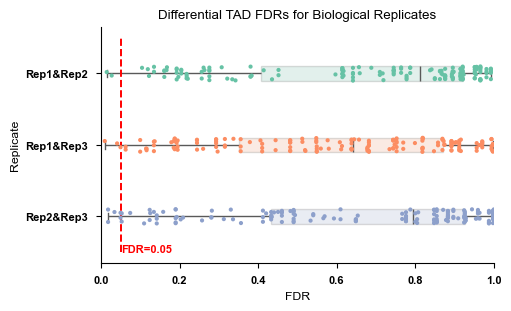

In [28]:
fig, ax = plt.subplots(figsize=(5, 3))
sns.boxplot(diffbedpes, x="fdr", y="Replicate", fill=True,
            boxprops={"alpha": .2},
            orient="h", width=.2, palette="Set2", ax=ax)
sns.stripplot(diffbedpes, x="fdr", y="Replicate",
              size=3, orient="h", palette="Set2", ax=ax)
ax.set(xlim=(0,1), xlabel="FDR")
ax.set(title="Differential TAD FDRs for Biological Replicates")
# ax.tick_params(axis="y", labelrotation=70)
ax.text(.05, ax.get_ylim()[0], s="FDR=0.05", fontsize=8, color="r")
ax.vlines(.05, *ax.get_ylim(), linestyles="--", color="r")
out_fname = os.path.join(out_dire, f"{lbl}_biol_rep_tad.pdf")
fig.savefig(out_fname, bbox_inches="tight")

## Differential loop calling demo

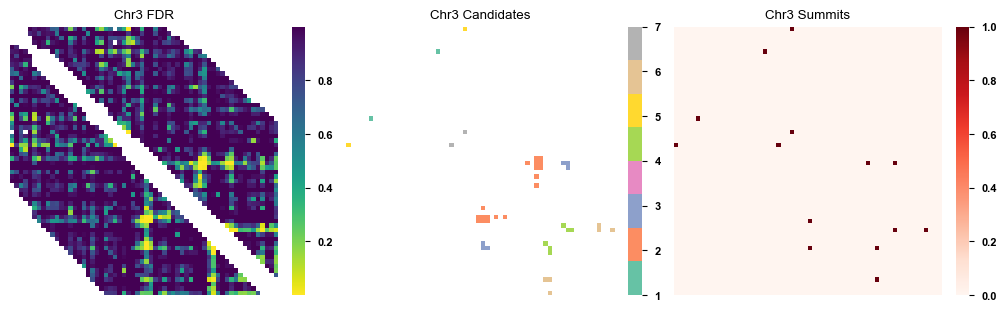

In [6]:
loop_data = mfr[("label","Ex"),("Replicate","rep1")]
chr_id = "chr3"
slc1 = sf.loop.LoopCaller(loop_data, 'carr', fdr_cutoff=.1, gap=75e3)
res1 = slc1.loops_from_single_chr(chr_id, sf.loop.AxisWiseF)
bedpe1 = slc1.to_bedpe(res1, chr_id)
fig, axes = plt.subplots(1, 3, figsize=(10, 3))
sf.pl.pairwise_heatmap(res1["fdr"], cmap="viridis_r", 
                       title=f"{chr_id.title()} FDR", ax=axes[0])
sf.pl.pairwise_heatmap(res1["label"], cmap="Set2", 
                       title=f"{chr_id.title()} Candidates", ax=axes[1])
sf.pl.pairwise_heatmap(res1["summit"], cmap="Reds", 
                       title=f"{chr_id.title()} Summits", ax=axes[2])
out_fname = os.path.join(out_dire, f"Ex_loop_{chr_id}_rep1.pdf")
fig.savefig(out_fname, bbox_inches="tight")

/Users/redfishhh/Documents/research/MultiplexedFISH/LoopTests/snapfish2/analysis/loop.py:768: RuntimeWarning: invalid value encountered in divide
  f_pvals = stats.f.cdf(var1/var2, count1, count2)


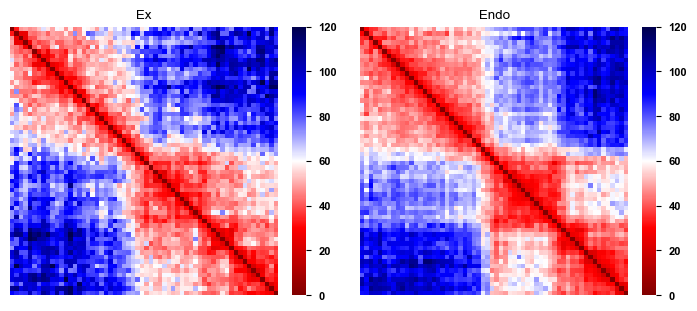

In [8]:
data1, data2 = mfr[chr_id, ("label","Ex")], mfr[chr_id, ("label","Endo")]
sdl = sf.loop.DiffLoop(data1, data2, "carr")
fdr_mat = sdl.diff_loops(bedpe1[bedpe1.summit])[chr_id]["fdr"]

arr1 = sf.utils.load.to_very_wide(data1)[1]
dist1 = np.nanmedian(np.sqrt(np.sum(np.square(arr1), axis=1)), axis=0)
arr1 = sf.utils.load.to_very_wide(data2)[1]
dist1 = np.nanmedian(np.sqrt(np.sum(np.square(arr1), axis=1)), axis=0)

fig, axes = plt.subplots(1, 2, figsize=(7, 3))
sf.pl.pairwise_heatmap(dist1, ax=axes[0], title="Ex", vmax=120)
sf.pl.pairwise_heatmap(dist2, ax=axes[1], title="Endo", vmax=120)
out_fname = os.path.join(out_dire, f"Ex_Endo_{chr_id}_hm.pdf")
fig.savefig(out_fname, bbox_inches="tight")

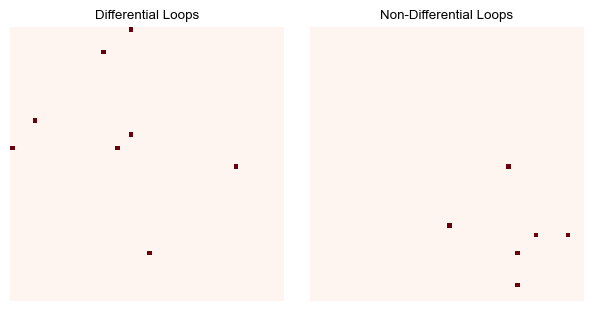

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(6, 3))
sf.pl.pairwise_heatmap(fdr_mat < .1, cmap="Reds", ax=axes[0], cbar=False,
                       title="Differential Loops")
sf.pl.pairwise_heatmap(fdr_mat >= .1, cmap="Reds", ax=axes[1], cbar=False,
                       title="Non-Differential Loops")
out_fname = os.path.join(out_dire, f"Ex_Endo_diff_loops_{chr_id}.pdf")
fig.savefig(out_fname, bbox_inches="tight")